In [100]:
import torch
import torch.nn as nn
import torch.optim as optim
from random import randint, uniform, gauss
import math
import numpy as np
import matplotlib.pyplot as plt

In [109]:
C_train = 100000
alpha = 0.23
error_all = 0.23

X_train = []
y_train = []
for i in range(C_train):
    xi = uniform(0, 5)
    eps = gauss(0, error_all)
    si = xi + eps
    xi1 = math.exp(alpha * si + eps)
    X_train.append([xi])
    y_train.append([xi1])

X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, 1)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

In [110]:
backbone = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU())

head_x = nn.Linear(32, 1)
head_sigma = nn.Linear(32, 1)
softplus = nn.Softplus()

params = list(backbone.parameters()) + list(head_x.parameters()) + list(head_sigma.parameters())
opt = optim.Adam(params, lr=10**(-3))

In [111]:
batch = 1024
epochs = 30

for k in range(epochs):
    pos = torch.randperm(X_train.size(0))
    ans = 0
    cnt = 0
    for i in range(0, X_train.size(0), batch):
        ind = pos[i:i + batch]
        x_now = X_train[ind]
        y_now = y_train[ind]
        
        res = backbone(x_now)
        x_ok = softplus(head_x(res))
        sigma_ok = softplus(head_sigma(res)) + 1e-6
        loss = ((y_now - x_ok) ** 2) / (2.0 * sigma_ok ** 2) + torch.log(sigma_ok)
        loss = loss.mean()

        opt.zero_grad()
        loss.backward()
        opt.step()
        ans += loss.item()
        cnt += 1

    print("iter ", k + 1, ", loss = ", ans / cnt, sep='')

iter 1, loss = 0.2844149952074893
iter 2, loss = -0.11837918946177375
iter 3, loss = -0.12375149043390946
iter 4, loss = -0.12374792339242234
iter 5, loss = -0.12421614349800714
iter 6, loss = -0.12460746190377645
iter 7, loss = -0.1249484654363929
iter 8, loss = -0.12494651410652667
iter 9, loss = -0.1244733328455869
iter 10, loss = -0.12488454382638542
iter 11, loss = -0.125080583807157
iter 12, loss = -0.1248846213732447
iter 13, loss = -0.12513792324735193
iter 14, loss = -0.12449612259408649
iter 15, loss = -0.12498774660789237
iter 16, loss = -0.12527750858238765
iter 17, loss = -0.12495704272723927
iter 18, loss = -0.12522792610891012
iter 19, loss = -0.12480220377293168
iter 20, loss = -0.12479739750222284
iter 21, loss = -0.12491212503946557
iter 22, loss = -0.1252613118564596
iter 23, loss = -0.12476171115983506
iter 24, loss = -0.12514733053667812
iter 25, loss = -0.12523043292517566
iter 26, loss = -0.12546248589547312
iter 27, loss = -0.12512884155980178
iter 28, loss = -0

In [112]:
C_test = 10000
X_test = []
y_test = []
for i in range(C_test):
    xi = uniform(0, 3)
    eps = gauss(0, error_all)
    
    si = xi + eps
    xi1 = math.exp(alpha * si + eps)
    X_test.append([xi])
    y_test.append([xi1])

X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

mse_x = 0
nll = 0
for i in range(C_test):
    h = backbone(X_test[i])
    x_ok = softplus(head_x(h))
    sigma_ok = softplus(head_sigma(h)) + 1e-6
    mse_x += (y_test[i][0] - x_ok[0]) ** 2
    nll += (((y_test[i][0] - x_ok[0]) ** 2) / (2.0 * sigma_ok[0] ** 2) + torch.log(sigma_ok[0]))

mse_x /= C_test
nll /= C_test
print("MSE x =", mse_x.item())
print("NLL =", nll.item())


MSE x = 0.19966503977775574
NLL = -0.3450133204460144


In [113]:
C_iter = 20
col_test = 1000

need_x = [0] * (C_iter + 1)
res_x = [0] * (C_iter + 1)
sum_error_x = [0] * (C_iter + 1)

for iter1 in range(col_test):
    x0 = uniform(0, 1.1)
    x = torch.tensor([[x0]], dtype=torch.float32)
    x_true = torch.tensor([[x0]], dtype=torch.float32)
    res_x[0] += x0
    need_x[0] += x0

    for i in range(C_iter):
        eps = gauss(0, error_all)
        si = x_true + eps
        x_true = torch.exp(alpha * si + eps)

        need_x[i + 1] += x_true.item()

        h = backbone(x)
        x_ok = softplus(head_x(h))
        sigma_ok = softplus(head_sigma(h)) + 1e-6
        x = x_ok + sigma_ok * torch.randn_like(x_ok)
        x = torch.clamp(x, min=1e-6)
        res_x[i + 1] += x.item()

        sum_error_x[i + 1] += (x_true.item() - x.item()) ** 2

for i in range(C_iter + 1):
    need_x[i] /= col_test
    res_x[i] /= col_test
    sum_error_x[i] /= col_test

need_x = np.array(need_x)
res_x = np.array(res_x)
sum_error_x = np.array(sum_error_x)


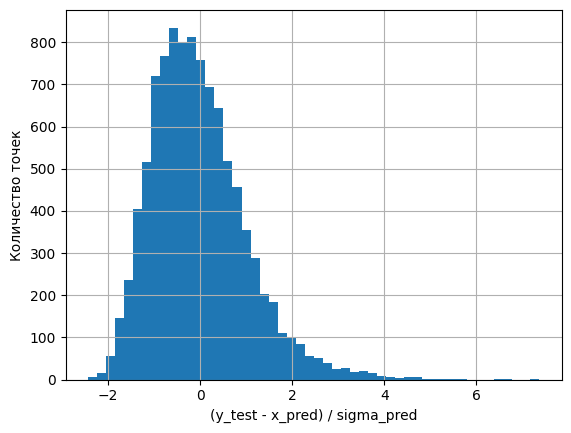

Процент результатов предсказания в отрезке [x - σ; x + σ] 70.00999999999999
Процент результатов предсказания в отрезке [x - 2σ; x + 2σ] 95.6


In [121]:
import numpy as np
import torch
import matplotlib.pyplot as plt

backbone.eval()
head_x.eval()
head_sigma.eval()
with torch.no_grad():
    h = backbone(X_test)
    xi1 = softplus(head_x(h)).squeeze(1).cpu().numpy()
    si1 = (softplus(head_sigma(h)) + 1e-6).squeeze(1).cpu().numpy()

x_test_now = X_test.squeeze(1).cpu().numpy()
y_test_now = y_test.squeeze(1).cpu().numpy()
plt.figure()
plt.hist(z, bins=50)
plt.xlabel("(y_test - x_pred) / sigma_pred")
plt.ylabel("Количество точек")
plt.grid(True)
plt.show()

cnt1 = 0
cnt2 = 0
all1 = 0
for i in range(len(y_test_now)):
    now = xi1[i]
    sigma_now = si1[i]
    if now - sigma_now < y_test_now[i] < now + sigma_now:
        cnt1 += 1
    if now - 2 * sigma_now < y_test_now[i] < now + 2 * sigma_now:
        cnt2 += 1
    all1 += 1

print("Процент результатов предсказания в отрезке [x - σ; x + σ]", cnt1 / all1 * 100)
print("Процент результатов предсказания в отрезке [x - 2σ; x + 2σ]", cnt2 / all1 * 100)


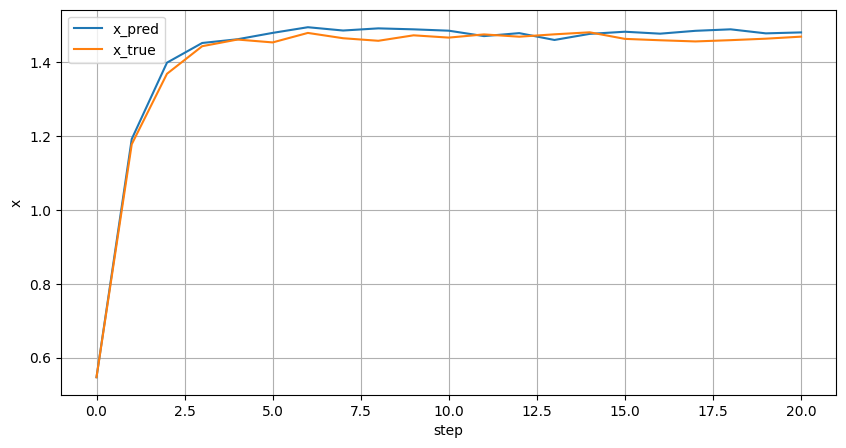

In [114]:
steps = np.arange(C_iter + 1)

plt.figure(figsize=(10, 5))
plt.xlabel("step")
plt.ylabel("x")
plt.plot(steps, res_x, label="x_pred")
plt.plot(steps, need_x, label="x_true")
plt.grid()
plt.legend()
plt.show()